# Multi-Class Text Classification

![alt text](https://miro.medium.com/max/966/0*X7PVc7QwrpFnyo4p.png)


In this project, we will create a model to predict the label of class, given the `text`. In the following post, we will walk through series of steps on how to get started with building model using [Google Colab](https://colab.research.google.com/). We will go through detail process on each step on how to approach to classfication problem. 


### Structure of project

1. Introduction
    - Classification

2. Data Understanding
    - Load data
    - Check for null and missing values
    - Check for duplicated rows
    - Label Encoding
3. Data Preperation
    - Lowercase
    - Stopwords
    - Tokenization 
    - Lemmentation
4. Model Preperation 
    - Define the model 
    - Set the optimizer 
5. Model Evaluation 
    - Hyperparameter tuning
6. Prediction and submission
    - Export model 
    - Import model


## Getting started

For this problem, we are given two CSV files, `train_set.csv` and `test_set.csv`. We are going to use the training file to train and test the model, and we then use the model to predict the unknown values in the text file. The first steps are to read in the files and perform some preliminary analysis to determine what pre-processing we will need before attempting to train a model.


In [0]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# installing libraries requiered for this project

# imblearn for smote algorithm: balancing dataset
!pip install imblearn

# installing autotime
!pip install ipython-autotime

# installing word segment
!pip install wordsegment 

## Import libraries

Let's now import the required libraries and load the dataset into our application. The following script imports the required libraries:

In [4]:
import re
import string
from string import punctuation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# importing for wordcloud
import collections 
from wordcloud import WordCloud

# importing for text processing 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import TextBlob
from textblob import Word
from wordsegment import load, segment 
load()

# 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score


# sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# keras
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,Flatten,LSTM, SpatialDropout1D,Activation
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Conv1D, GlobalMaxPooling1D,Dropout

# pickle
import pickle

# 
np.random.seed(500)

# 
%load_ext autotime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# setting properties of datafrme 

# column display size
pd.set_option("display.max_colwidth", 300)

# warrning option
pd.set_option('mode.chained_assignment', None)

time: 1.28 ms


## Data Understanding

There are 12 output labels for each text: . A text can belong to all of these categories ,which makes it a multi-label classification problem.

We will use both "train_set.csv" and "test_set.csv" file that contains 23615 and 5894 records respectively.

### 2.1 Load data 

Now lets load data into the memory.


In [6]:
# load the data
train = pd.read_csv('train_set.csv',  encoding='latin-1')
test = pd.read_csv('test_set.csv',  encoding='latin-1')
print(train.shape)
train.head()

(23615, 2)


,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for circuit breaker captive consumption
2,85389000,lv ma pd trip unit for cvs parts of circuit breakers
3,85389000,lv na p trip unit for cvs switch parts of circuit breaker
4,85389000,lv tmd pd trip unit for cvs parts of circuitbreakers


time: 71.4 ms


The dataset contains 23615 records and 2 columns. The header of the dataset is up above.

Once the files have been imported we will try to understand more about data and get some more information about the dataset.

In [7]:
def describe_data(df):
    print("Data Types:")
    print(df.dtypes)
    print("Rows and Columns:")
    print(df.shape)
    print("Column Names:")
    print(df.columns)
    print("Null Values:")
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))
    print("Duplicated rows:")
    duplicate_rows = train[train.duplicated()]
    print("Duplicated rows: " ,len(duplicate_rows))

describe_data(train)

Data Types:
label     int64
text     object
dtype: object
Rows and Columns:
(23615, 2)
Column Names:
Index(['label', 'text'], dtype='object')
Null Values:
label    0.0
text     0.0
dtype: float64
Duplicated rows:
Duplicated rows:  12243
time: 27.5 ms


This gives the following information about the data set;
- That we have text column as non numeric which will need some pre-processing before they can be used to build a model.
- That we have a relatively small data set consisting of 11372 rows and 2 columns.
- That there are no null values present in the data
- Thata there are 12243 duplicated rows which has to be removed.

85389000    2936
85177090    2581
85369090    2438
39269099    2189
73181500    2033
85366990    1944
85238090    1720
85364900    1714
87089900    1673
33041000    1605
87082900    1451
84713010    1331
Name: label, dtype: int64

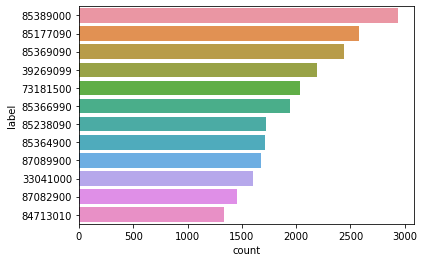

time: 177 ms


In [8]:
# plot the frequency of each class
sns.countplot(y = 'label',
              data = train,
              order = train['label'].value_counts().index)

# occurence of each class
train['label'].value_counts()

There are 12 distinct classes and all classes don't have balanced distribution of data. We can see class `85389000` (2936 rows) have more dataset that class `84713010`(1331 rows). 

If we train classifier on this data, the accuracy of the classifier would be maximum for class `85389000` (top row) and for class (below row) the model treats it as minority class. So, we need to balance our data. 

To balance imbalanced dataset there are multiple approaches we has been discussed below.


In [9]:
# replacing labels with new encoded labels
# The labels are replaced from number 1 to 12 
# such that 1 has highest number of distribution i.e 2926
# and 12 has the lowest number of distribution i.e. 1331


replace_values = {85389000 : 1, 85177090 : 2, 85369090 : 3, 39269099 : 4,
                  73181500 : 5, 85366990 : 6, 85238090 : 7, 85364900 : 8, 87089900 : 9,
                  33041000 : 10 ,87082900 : 11 , 84713010 : 12 }   

train = train.replace({"label": replace_values})                                                                                             

# occurence of each class
train['label'].value_counts()

1     2936
2     2581
3     2438
4     2189
5     2033
6     1944
7     1720
8     1714
9     1673
10    1605
11    1451
12    1331
Name: label, dtype: int64

time: 12.8 ms


1     2936
2     2581
3     2438
4     2189
5     2033
6     1944
7     1720
8     1714
9     1673
10    1605
11    1451
12    1331
Name: label, dtype: int64

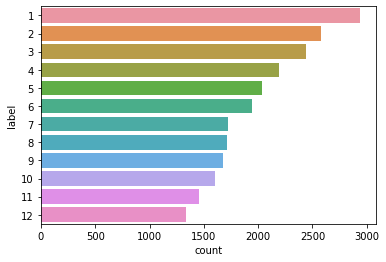

time: 156 ms


In [10]:
# plot the frequency of each class
sns.countplot(y = 'label',
              data = train,
              order = train['label'].value_counts().index)

# occurence of each class
train['label'].value_counts()

Each class has been label to corresponding values from 1 to 12. This makes it easier to read each class. 

## Data Pre-processing


Most machine learning models are unable to handle non-numeric columns, and missing values in data. It is therefore necessary to perform a number of pre-processing steps.

Once the dataset has been imported, the next step is to preprocess the text. Text may contain numbers, special characters, and unwanted spaces. Depending upon the problem we face, we may or may not need to remove these special characters and numbers from text. However, for the sake of explanation, we will remove all the special characters, and unwanted spaces from our text. 
- Remove duplicated rows 
- Lowercase
- Remove punctuation
- Remove stopwords
- Spelling correction
- Tokenization 



In [11]:
def clean_dataset(df):
  """
  Data cleaning and processing of text data. 

  INPUT:
  df: dataframe(object): 

  OUTPUT
  df: dataframe(object): cleaned dataframe object for 
  """

  # duplicated rows
  print("\nDroping duplicated rows . . .") 
  print("Total rows :", len(df))  
  df = df.drop_duplicates( keep='first')
  print("Total rows after removing duplicate :", len(df))

  # replacing more than one empty space
  print("\nReplacing more than one spaces . . . ")
  df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

  # lower case
  print("\nConverting to lowercase . . .")
  df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

  # replacing single words
  print("\nReplacing single words . . . ")
  df['text'] = df['text'].str.replace('[^\w\s]','')

  # stopwords
  print("\nReplacing stop words . . .") 
  df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # spelling correction 
  print("\nSpelling correction . . . .")
  train['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

  return df

time: 16 ms


In the script above we start by removing all duplicated rows from `label` and `text` column. 

Next, we remove all the single characters. To remove  single characters we use `\s+[a-zA-Z]\s+` regular expression which substitutes all the single characters having spaces on either side, with a single space.

Next, we use the `\^[a-zA-Z]\s+` regular expression to replace a single character from the beginning of the document, with a single space. Replacing single characters with a single space may result in multiple spaces, which is not ideal.

We again use the regular expression `\s+` to replace one or more spaces with a single space. When you have a dataset in bytes format, the alphabet letter "b" is appended before every string. The regex ^b\s+ removes "b" from the start of a string. The next step is to convert the data to lower case so that the words that are actually the same but have different cases can be treated equally.

The final preprocessing step is the use of stopwords. Stopwords are words that a search engine has been programmed to ignore. We would not want these words taking up space in our database, or taking up valuable processing time. So we will remove all those words. 

Finally we need to perform lemmatization, but lets further analyze how lemmatization can improve out model. To understand thise we will plot most frequent words with and without lemmatization and see how it can help us to build better model.


In [12]:
# cleaning train_set.csv

train= clean_dataset(train)
print("\nLength of training set:", len(train))


Droping duplicated rows . . .
Total rows : 23615
Total rows after removing duplicate : 11372

Replacing more than one spaces . . . 

Converting to lowercase . . .

Replacing single words . . . 

Replacing stop words . . .

Spelling correction . . . .

Length of training set: 11372
time: 1.09 s


In [13]:
# Cleaning test_set.csv dataset

print("Cleaning testing dataset . . . \n")
test  = clean_dataset(test)
print("\nLength of testing set:", len(test))

Cleaning testing dataset . . . 


Droping duplicated rows . . .
Total rows : 5894
Total rows after removing duplicate : 3849

Replacing more than one spaces . . . 

Converting to lowercase . . .

Replacing single words . . . 

Replacing stop words . . .

Spelling correction . . . .

Length of testing set: 3849
time: 873 ms


In [14]:
# Most frequent words on training set 
text_frequency_train_before_lemmatize = pd.Series(''.join(train['text']).split()).value_counts()[:50]

# Most frequent words on testing set 
text_frequency_test_before_lemmatize = pd.Series(''.join(test['text']).split()).value_counts()[:50]

time: 40.2 ms


`text_frequency_train_before_lemmatize` and `text_frequency_test_before_lemmatize` contains series of most frequent words without lemmatization. Now, lets plot these words on wordcloud and analyze the situation.

In [15]:
# counting the frequency of each word

def word_frequency(text_frequency, text):
  """
  Counts the repeatation of each word in the given string.

  INPUTS:
  text_frequency : Series: Most frequent words from training set.  
  text : String : Description about word cloud 

  OUTPUTS:
  """

  print(text)  

  # plotting word frequency
  wc = WordCloud().generate_from_frequencies(text_frequency)
  plt.figure(figsize=(10,8), facecolor='k')
  plt.imshow(wc)
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show() 

time: 4.18 ms


Top 50 most frequent words on training. . .


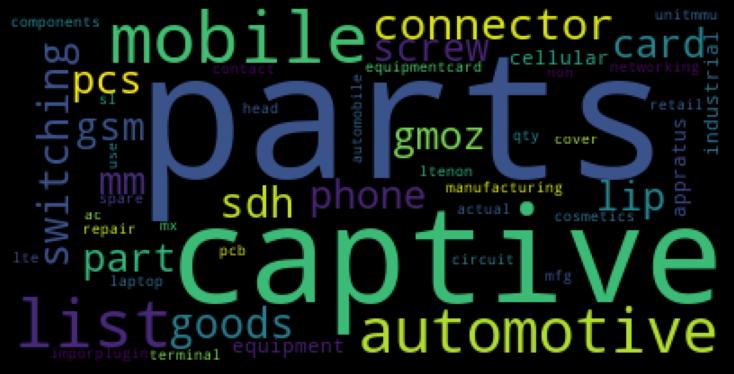

time: 324 ms


In [16]:
word_frequency(text_frequency_train_before_lemmatize,"Top 50 most frequent words on training. . .")

Top 50 most frequent words on testing set . . .


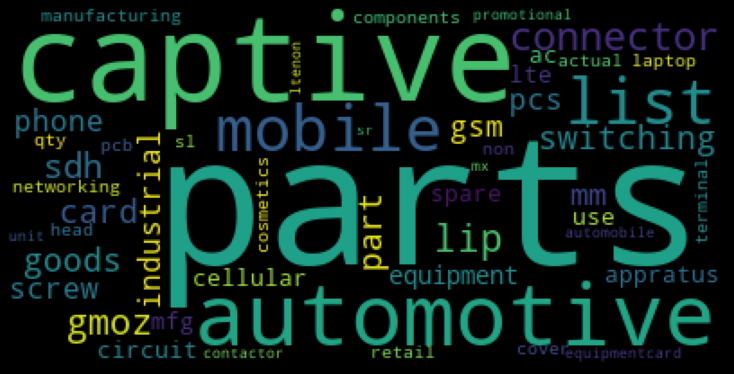

time: 325 ms


In [17]:
word_frequency(text_frequency_test_before_lemmatize, "Top 50 most frequent words on testing set . . .")

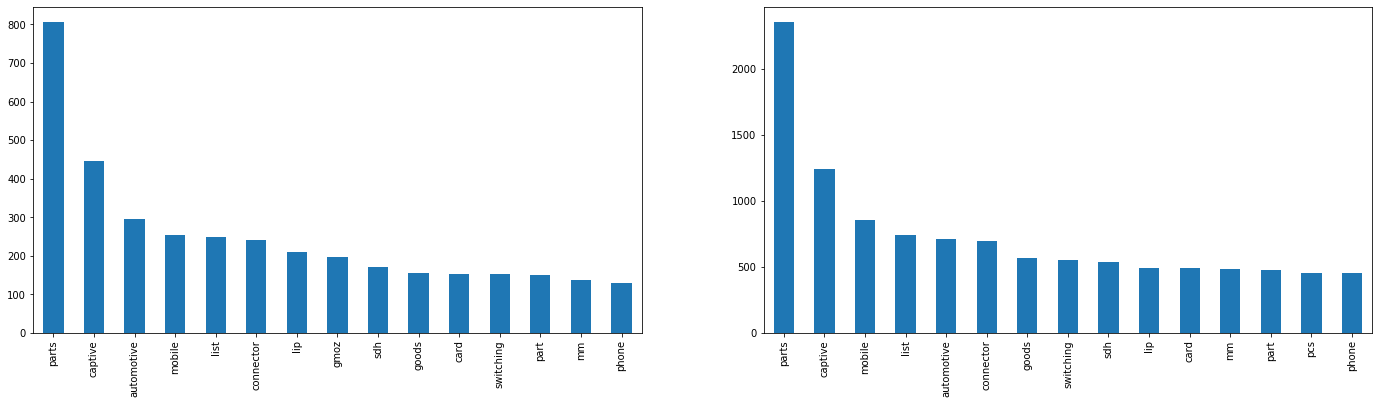

time: 400 ms


In [18]:
# plot the most 15 frequent words on training and testing file with number of its occurence

fig, axs = plt.subplots(1,2)
pd.Series(''.join(train['text']).split()).value_counts()[:15].plot(kind='bar', figsize=(24,6), ax=axs[1])
pd.Series(''.join(test['text']).split()).value_counts()[:15].plot(kind='bar', figsize=(24,6), ax=axs[0])

> As we can see, we have not performed text normalization, which is why many words are not reduced to its root form. However, this step colud be done in preprocessing step earlier. But I have used it here so we can see how the data processing is really happening.

> Here is an example, the word `parts` and `part` has repeated two times even though its root meaning is same.

> This can be elemintaed using `text normalization`, which has been performed in following section. 


### Text normalization 

Lemmatization: Lemmatization is simply normalization of words, which means reducing a word to its root form.




In [19]:
# lemmatization of training set
train['text'] = train['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# lemmatization of testing set
test['text'] = test['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


time: 1.91 s


In lemmatization, we reduce the word into dictionary root form. For instance "parts" is converted into "part". Lemmatization is done in order to avoid creating features that are semantically similar but syntactically different. For instance, we don't want two different features named "parts" and "part", which are semantically similar, therefore we perform lemmatization.

In [20]:
# Most frequent words on training set 
text_frequency_train_after_lemmatize = pd.Series(''.join(train['text']).split()).value_counts()[:50]

# Most frequent words on testing set 
text_frequency_test_after_lemmatize = pd.Series(''.join(test['text']).split()).value_counts()[:50]

time: 41.2 ms



> Lets again check most freqeunt words on training and testing file using `wordcloud.`




Top 50 most frequent word on training set . . .


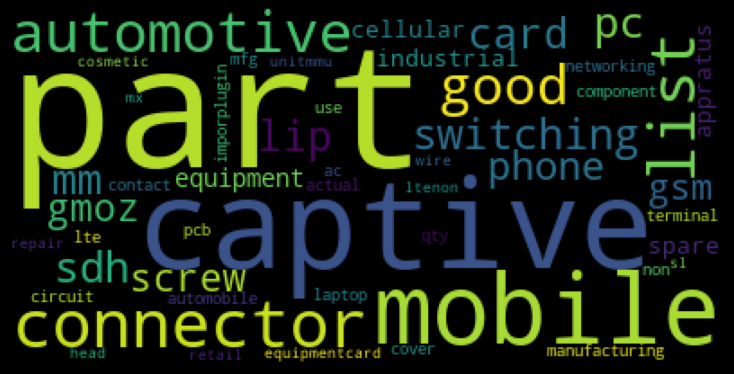

time: 318 ms


In [21]:
word_frequency(text_frequency_train_after_lemmatize,"Top 50 most frequent word on training set . . .")

Top 50 most frequent word on testing set . . .


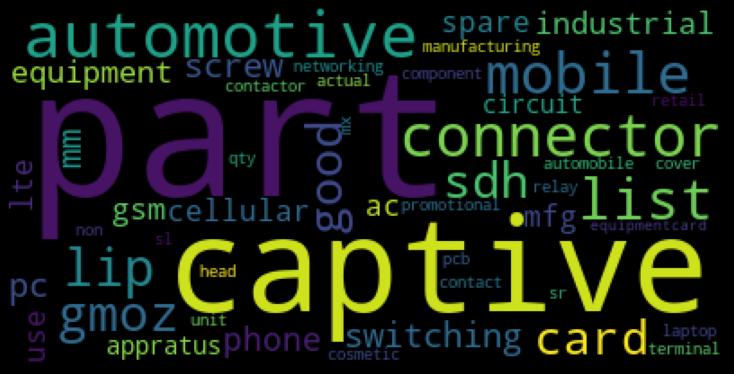

time: 308 ms


In [22]:
word_frequency(text_frequency_test_after_lemmatize,"Top 50 most frequent word on testing set . . .")

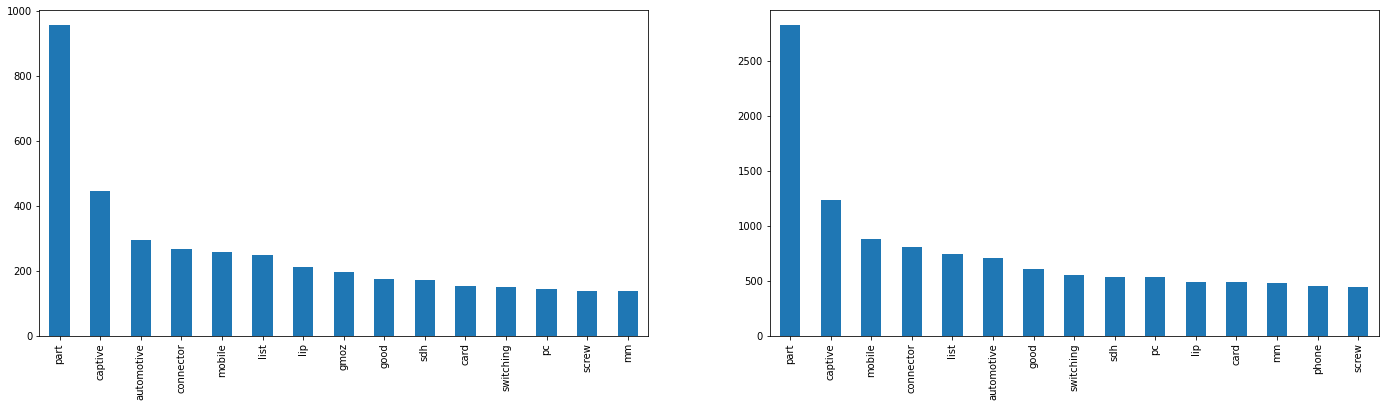

time: 398 ms


In [23]:
# plot the most 15 frequent words on training and testing file with number of its occurence

fig, axs = plt.subplots(1,2)

pd.Series(''.join(train['text']).split()).value_counts()[:15].plot(kind='bar', figsize=(24,6), ax=axs[1])
pd.Series(''.join(test['text']).split()).value_counts()[:15].plot(kind='bar', figsize=(24,6), ax=axs[0])

> As text normalization is performed, word such a `parts` and `part` is normalized to its root meaning 


> Our dataset has been furter cleaned.



# Converting text to number

Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert our text into numbers.

Different approaches exist to convert text into the corresponding numerical form. The `Bag of Words Model` and the `Word Embedding Model` are two of the most commonly used approaches. 

**Finding TFIDF** 

The bag of words approach works fine for converting text to numbers. However, it has one drawback. It assigns a score to a word based on its occurrence in a particular document. TFIDF resolves this issue by multiplying the term frequency of a word by the inverse document frequency. The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency".

The term frequency is calculated 

```
Term frequency = (Number of Occurrences of a word)/(Total words in the document)
```

And the Inverse Document Frequency is calculated as:

```
IDF(word) = Log((Total number of documents)/(Number of documents containing the word))
```



In [24]:
# seperating features and label column
y = train.label
x = train.drop('label',axis=1)

# list to hold text  
final_text = []

for word in x['text']:
  final_text.append(word)

# Vectorize and tokenize
tfidfconverter = TfidfVectorizer()
X = tfidfconverter.fit_transform(final_text).toarray()

time: 691 ms


# Training model 

Our dataset is unbalanced i.e. class distribution of each is not normally distributed.

> To see how imbalanced dataset affect our model performance. First lets train model without balancing and then by balancing dataset.

> The dataset will be trained on multiple classifiers and we will optimize every model and select most appropriate model.


### Training model without balanced dataset

Like any other supervised machine learning problem, we need to divide our data into training and testing sets. To do so, we will use the `train_test_split` utility from the `sklearn.model_selection` library. 

The script divides data into 20% test set and 80% training set.

In [25]:
# Train test split model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

time: 379 ms


To train our machine learning model using the random forest algorithm we will use `RandomForestClassifier` class from the sklearn.ensemble library. The `fit` method of this class is used to train the algorithm. We need to pass the training data and training target sets to this method. 


To evaluate the performance of a classification model such as the one that we just trained, we can use metrics such as the `confusion matrix`, `F1 measure`, and the `accuracy`.

To find these values, we can use `classification_report`, and `accuracy_score` utilities from the `sklearn.metrics` library. Execute the following script to do so:

In [26]:
# random forest classifier 
classifier = RandomForestClassifier(n_estimators=10, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# evaluation metrics 
print(classification_report(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.83      0.80       296
           2       0.92      0.94      0.93       314
           3       0.80      0.75      0.77       258
           4       0.65      0.83      0.73       297
           5       0.95      0.84      0.89       267
           6       0.81      0.71      0.76       201
           7       1.00      0.86      0.92        21
           8       0.86      0.82      0.84       105
           9       0.79      0.72      0.75       172
          10       1.00      1.00      1.00       117
          11       0.82      0.70      0.76       117
          12       0.97      0.96      0.97       110

    accuracy                           0.83      2275
   macro avg       0.86      0.83      0.84      2275
weighted avg       0.84      0.83      0.83      2275

Accuracy score:  0.8268131868131868
time: 5.97 s


In [34]:
# # logistic regression classifier
# from sklearn.linear_model import LogisticRegression
# classifier_lr = LogisticRegression(random_state=0)
# classifier_lr_pred = classifier_lr.fit(X_train, y_train).predict(X_test)

# # evaluation metrics 
# print(classification_report(y_test,classifier_lr_pred))
# print("Accuracy score: ", accuracy_score(y_test, classifier_lr_pred))

time: 978 µs


In [28]:
# naive bayes
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb_pred = classifier_nb.fit(X_train, y_train).predict(X_test)

# evaluation metrics 
print(classification_report(y_test,classifier_nb_pred))
print("Accuracy score: ", accuracy_score(y_test, classifier_nb_pred))

              precision    recall  f1-score   support

           1       0.78      0.63      0.70       296
           2       0.92      0.89      0.90       314
           3       0.78      0.56      0.65       258
           4       0.75      0.68      0.71       297
           5       0.79      0.76      0.78       267
           6       0.50      0.63      0.56       201
           7       0.44      0.86      0.58        21
           8       0.53      0.86      0.66       105
           9       0.60      0.58      0.59       172
          10       0.98      0.99      0.99       117
          11       0.61      0.81      0.70       117
          12       0.94      0.97      0.96       110

    accuracy                           0.73      2275
   macro avg       0.72      0.77      0.73      2275
weighted avg       0.75      0.73      0.74      2275

Accuracy score:  0.7331868131868132
time: 3.05 s


In [30]:
# decision tree
from sklearn import tree
classifier_dt = tree.DecisionTreeClassifier()
classifier_dt_pred = classifier_dt.fit(X_train, y_train).predict(X_test)

# evaluation metrics
print(classification_report(y_test, classifier_dt_pred))
print("Accuracy score :", accuracy_score(y_test, classifier_dt_pred))

              precision    recall  f1-score   support

           1       0.81      0.77      0.79       296
           2       0.90      0.93      0.92       314
           3       0.72      0.79      0.75       258
           4       0.63      0.81      0.71       297
           5       0.93      0.80      0.86       267
           6       0.82      0.70      0.76       201
           7       0.94      0.76      0.84        21
           8       0.91      0.83      0.87       105
           9       0.73      0.66      0.70       172
          10       1.00      1.00      1.00       117
          11       0.74      0.70      0.72       117
          12       0.98      0.94      0.96       110

    accuracy                           0.81      2275
   macro avg       0.84      0.81      0.82      2275
weighted avg       0.82      0.81      0.81      2275

Accuracy score : 0.8083516483516483
time: 20.1 s


In [27]:
# # support vector machine
# from sklearn import svm
# classifier_svm = svm.SVC()
# classifier_svm_pred = classifier_svm.fit(X_train, y_train).predict(X_test)

# # evaluation metrics 
# print(classification_report(y_test,classifier_svm_pred))
# print("Accuracy score: ", accuracy_score(y_test, classifier_svm_pred))

time: 615 µs


**The accuracy comes out to be 82% but lets check if after balancing our dataset if accuracy of our model increases or not.**

## Handling the unbalanced dataset

There are multiple ways to handle unbalanced dataset. In this project we will implement **resampling techniques.**

**RESAMAPLING:**  SMOTE oversampling technique where the minority class is oversampled to increase the number of instances of that classes.

SMOTE (Synthetic Minority Oversampling Technique) -
It is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. 

**Using SMOTE Algorithm**

You can check all the parameters from [link text](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)




In [31]:
# Here we will check oversampling of low and high distribution class. i.e. class 1 and class 12.

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '12': {} \n".format(sum(y_train == 12))) 

from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '12': {}".format(sum(y_train_res == 12))) 


Before OverSampling, counts of label '1': 1261
Before OverSampling, counts of label '12': 454 

After OverSampling, the shape of train_X: (15972, 13490)
After OverSampling, the shape of train_y: (15972,) 

After OverSampling, counts of label '1': 1331
After OverSampling, counts of label '12': 1331
time: 3min 12s


Now that we have balanced class distribution of dataset, we will again train the model and check overall performance on all class.

In [41]:
# random forest classifier
clf_rf = RandomForestClassifier(n_estimators=10, random_state=0)
clf_nb_pred = clf_rf.fit(X_train_res, y_train_res.ravel()).predict(X_test)

# naive bayes
clf_nb = GaussianNB()
clf_nb_pred = clf_nb.fit(X_train_res, y_train_res.ravel()).predict(X_test)

# decison tree
clf_dt = tree.DecisionTreeClassifier()
clf_dt_pred = clf_dt.fit(X_train_res, y_train_res.ravel()).predict(X_test)


# evaluating the model
print("\nEvaluating the model\n")
print("Accuracy of random forest: {}" .format(accuracy_score(y_test, clf_rf_pred)))
print("Accuracy of naive bayes: {}".format(accuracy_score(y_test, clf_nb_pred)))
print("Accuracy of decision tree: {}".format(accuracy_score(y_test, clf_dt_pred)))


Evaluating the model

Accuracy of random forest: 0.8364835164835165
Accuracy of naive bayes: 0.7336263736263736
Accuracy of decision tree: 0.8079120879120879
time: 46.1 s


## Accuracy Result 
                      

>Classifier | Before resampling | After resampling
>--- | --- | ---
>Random Forest | 82.68% | 83.64% 
>Naive Bayes | 73.31% | 43.36%
>Decsion Tree | 80.85% | 80.79%


# Exporting model

Machine learning model can take much time to execute. Our model didn't take much time for training set. But if there are millions of documents and the features are also in thousand then the machine learning model can take hours or even day in most cases. So it is recommended to export the machine learning model. 


Once you execute the above script, you can see the `text_classifier` file in your working directory. We have saved our trained model and we can use it later for directly making predictions, without training.

> We loaded our trained model and stored it in the `new_model` variable. Let's predict the sentiment for the test set using our loaded model and see if we can get the same results. 

> We loaded our trained model and stored it in the `new_model` variable. Let's predict the sentiment for the test set using our loaded model and see if we can get the same results. 

# Conclusion

Text classification is one of the most common natural language processing tasks. In this project we classified text into 12 different classe using Keras deep learning library. We used two different types of neural networks to classify text and labels. The results show that LSTM, which is a variant of RNN outperforms both the CNN and Random Forest.
